In [1]:
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
torch.manual_seed(999)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
working_dir = '/media/jswaney/Drive/Justin/MNIST'

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [111]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(working_dir, 'data'),
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=5000,
    shuffle=True,
    **kwargs)

In [15]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(working_dir, 'data'),
                   train=False,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=64,
    shuffle=True,
    **kwargs)

In [7]:
class VAE(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 400)
        # Encode to mean and stdev of normal distributions
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
    
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        # for reconstruction and KL divergence from unit normal
        return self.decode(z), mu, logvar

In [8]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [9]:
# These loss functions need to be defined using tensors for automatic differentiation
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [24]:
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {} Ave loss: {:.4f}'.format(epoch, train_loss/len(train_loader.dataset)))

In [25]:
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += vae_loss(recon_batch, data, mu, logvar).item()
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [19]:
import matplotlib.pyplot as plt

Epoch: 1 Ave loss: 106.0958
====> Test set loss: 105.6121


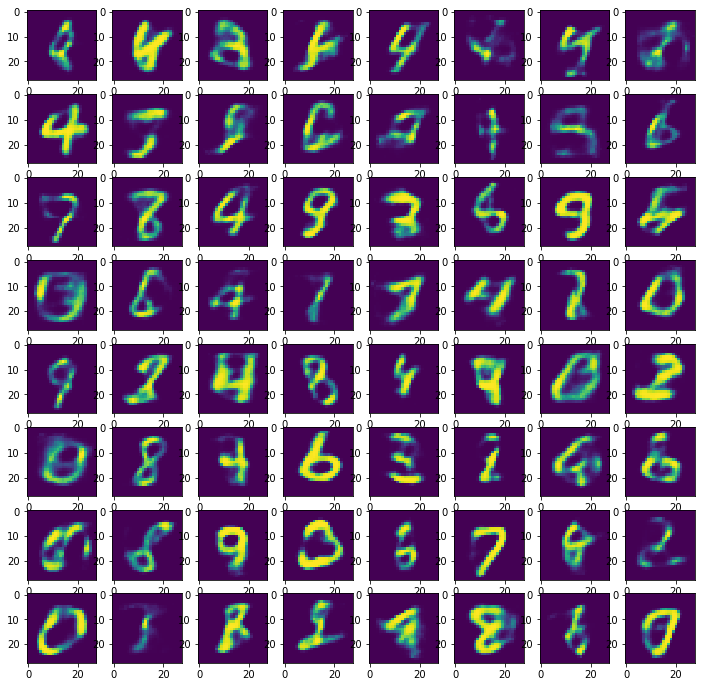

Epoch: 2 Ave loss: 105.7606
====> Test set loss: 105.1143


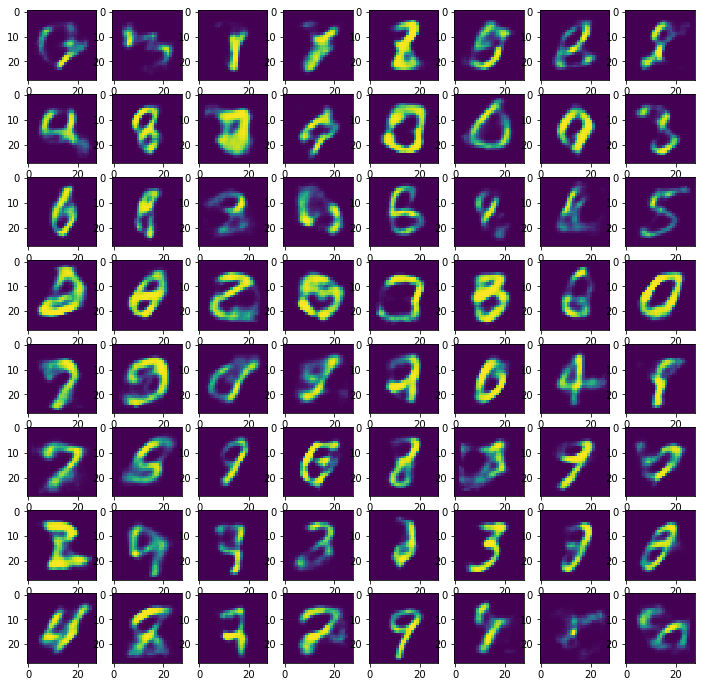

Epoch: 3 Ave loss: 105.4233
====> Test set loss: 104.8277


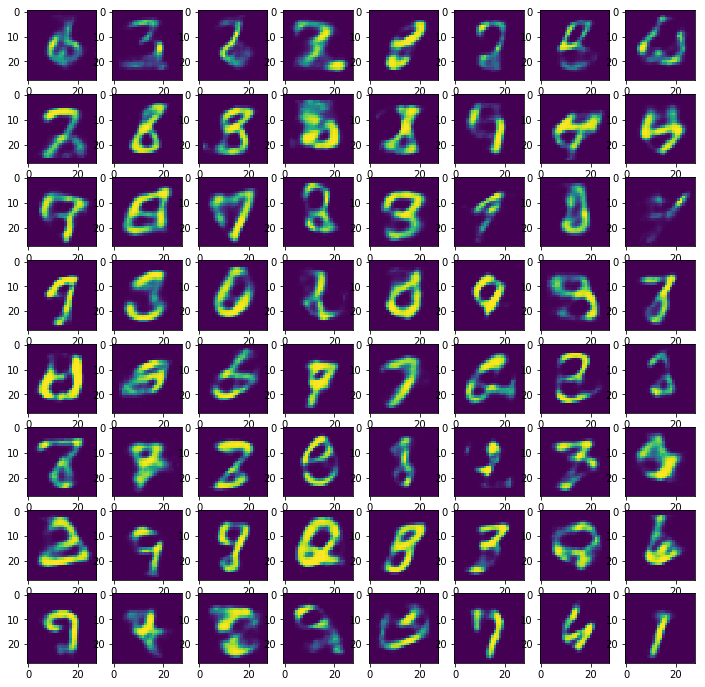

Epoch: 4 Ave loss: 105.1718
====> Test set loss: 105.3679


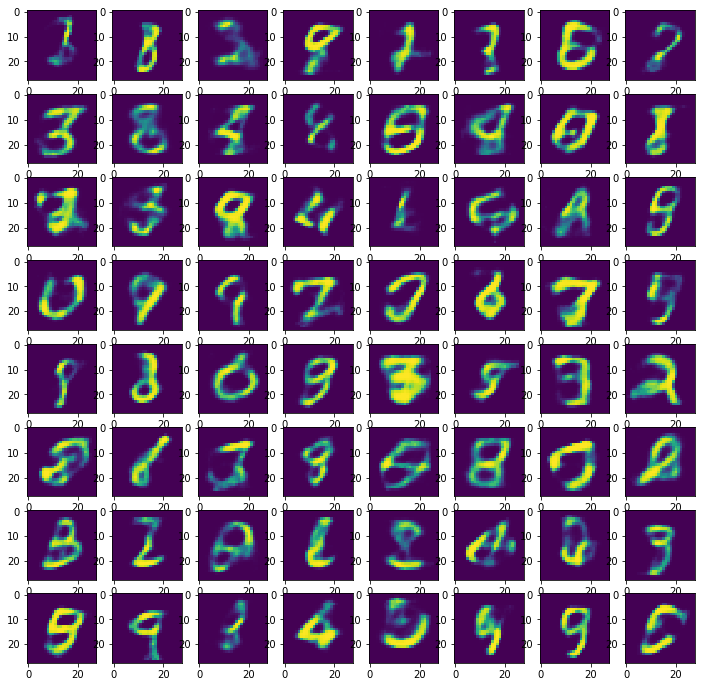

Epoch: 5 Ave loss: 104.8653
====> Test set loss: 104.7050


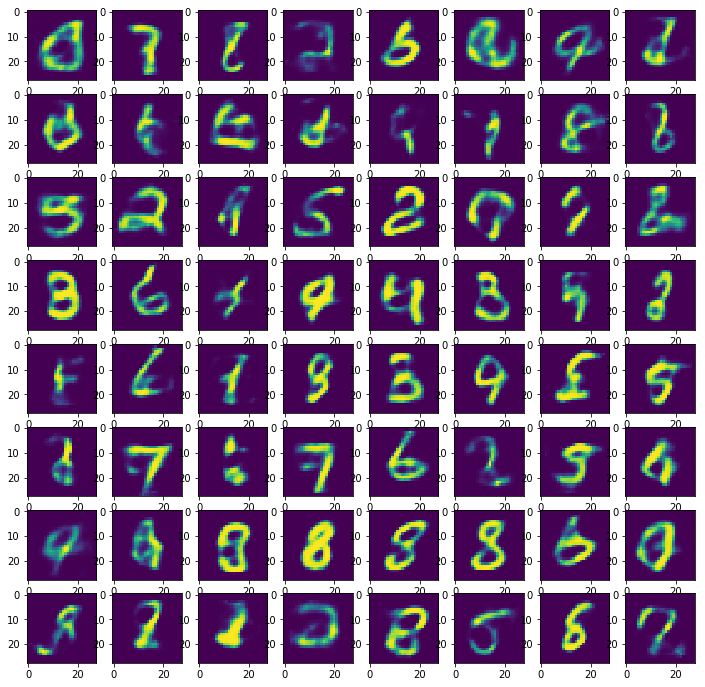

In [26]:
for epoch in range(1, 5 + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = torch.randn(64, 20).to(device)  # Sample from standard normal
        sample = model.decode(sample).cpu().numpy()
    plt.figure(figsize=(12, 12))
    for i, x in enumerate(sample):
        img = x.reshape(28, 28)
        plt.subplot(8, 8, i+1)
        plt.imshow(img)
    plt.show()

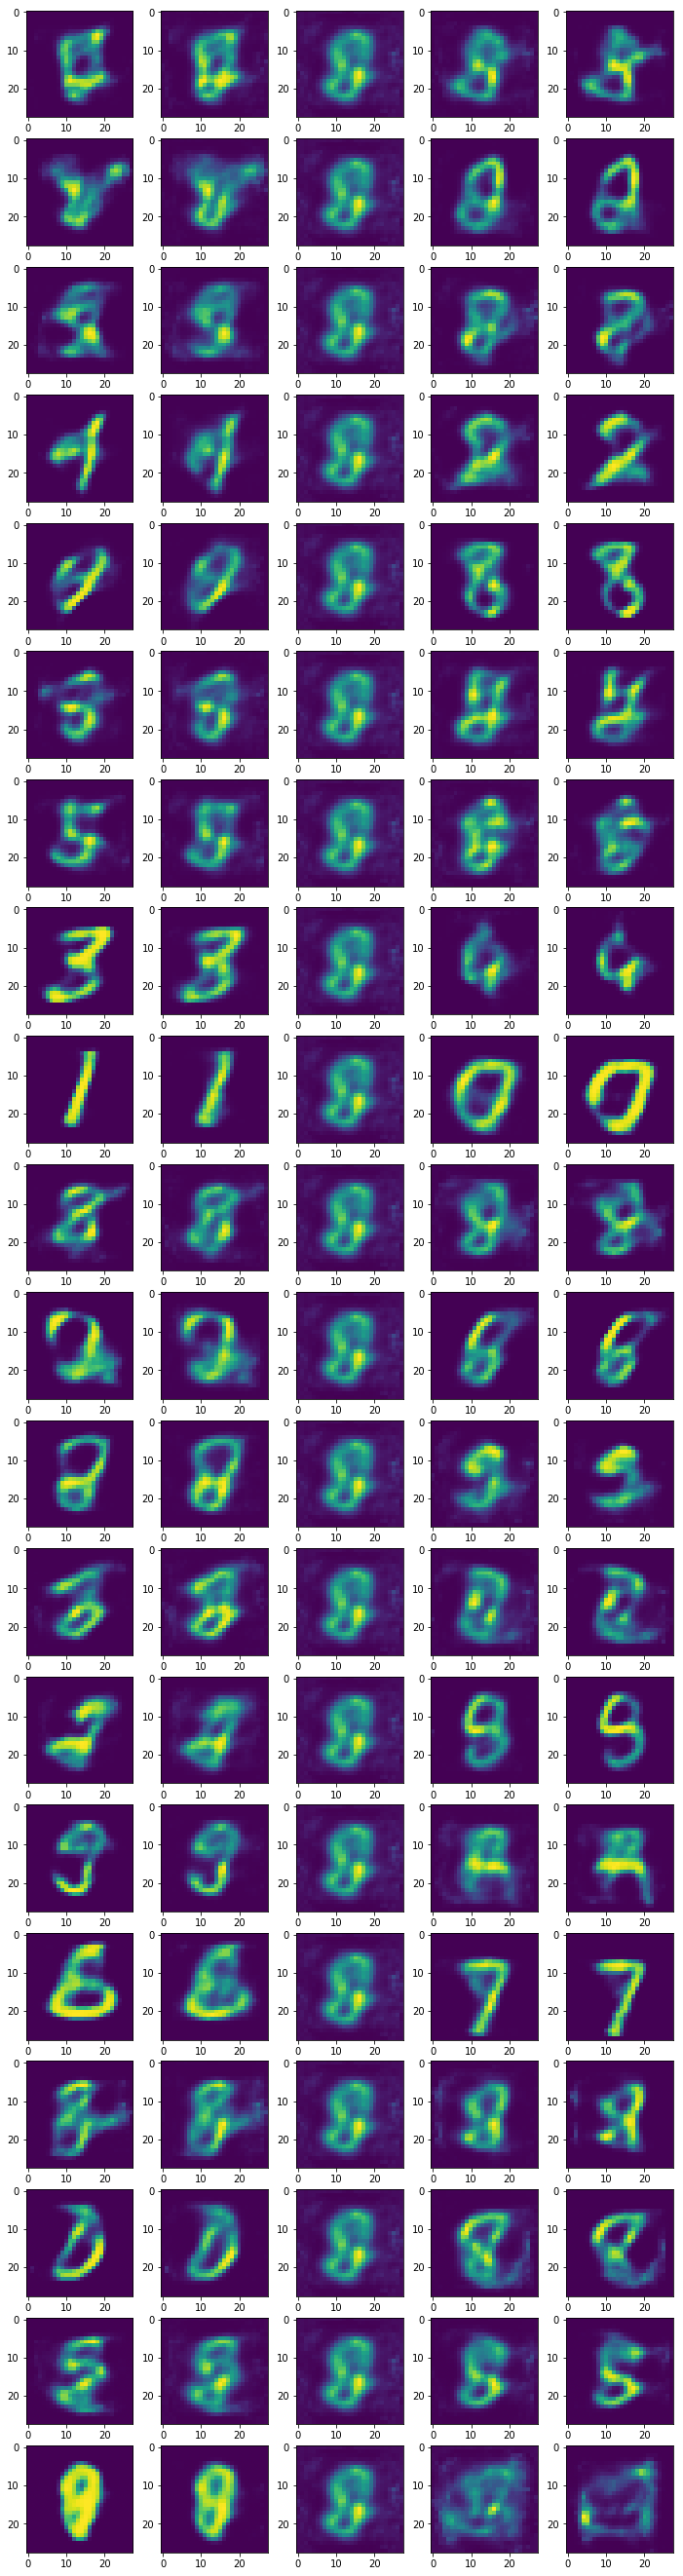

In [87]:
nb_samples = 5
nb_dim = 20
zrange = [-3, 3]
plt.figure(figsize=(12, 48))

idx = 1
for d in range(nb_dim):
    sample = torch.zeros(nb_samples, nb_dim)
    sample[:, d] = torch.linspace(zrange[0], zrange[1], nb_samples)
    with torch.no_grad():
        sample = model.decode(sample).cpu().numpy()
    for i, x in enumerate(sample):
        img = x.reshape(28, 28)
        plt.subplot(nb_dim, nb_samples, idx)
        plt.imshow(img)
        idx += 1
plt.show()

In [112]:
x, y = next(iter(train_loader))

In [113]:
X, Y = x.numpy(), y.numpy()

In [114]:
mu, logvar = model.encode(x.view(-1, 784))

In [115]:
MU = mu.detach().numpy()

In [116]:
from sklearn.decomposition import PCA

In [117]:
pca = PCA(n_components=2).fit_transform(MU)

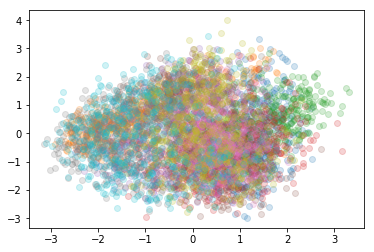

In [121]:
for l in range(10):
    idx = np.where(Y == l)[0]
    if len(idx) == 0:
        continue
    plt.plot(pca[idx, 0], pca[idx, 1], 'o', alpha=0.2)
plt.show()